# Setup

In [25]:
dataset_name = "EmoEvent (Tokenized)"     # Name of the dataset to use. See config_files/dataset_config.py
include_unlabeled_labels = False        # True: Includes "others" or similar labels for records that did not fit specific classes.

# Reducing amount of real data per class by...
trim_type = None     # Options: ratio, value, or None
trim_to_ratio = 0.10
trim_to_value = 25

# Augmenting
augmenting_llm = "Llama3.1 8B instruct-q8" # Name of the model used for augmenting. See config_files/LLM_config.py

augment_all = False
augment_by = "multiplier"                # Options: "balance", "initial size", "multiplier", "add", None
augment_add = 300
augment_min_size = 500
augment_scalar = 3.0
augment_classes = {"anger": 2.0, "fear": 2.0, "surprise": 2.0}    # List of classes to augment, if none then will apply to all.

# Classifier Settings
classifier = "roberta"
model = "roberta-base"
epochs = 2

# Randomization Seed Values
train_test_random_seed = 42
trim_random_seed = 42
augment_random_seed = 42
shuffle_random_seed = 42
classifier_random_seed = 42


# Imports

In [26]:
import torch

print("CUDA Enabled? " + str(torch.cuda.is_available())) 
if torch.cuda.is_available():
    print("Device: " + torch.cuda.get_device_name())

CUDA Enabled? True
Device: NVIDIA GeForce RTX 3080 Ti


## Config Files

In [27]:
from config_files import dataset_config
from config_files import LLM_config

# Workflow
## Real Data

In [28]:
dataset_metadata = dataset_config.dataset[dataset_name]

### Loading

In [29]:
import pandas as pd

df_real = pd.DataFrame([])

if dataset_metadata["location"] == "local":

    if dataset_metadata["filetype"] == "csv":
        df_real = pd.read_csv(dataset_metadata["abspath"])
        
    elif dataset_metadata["filetype"] == "tsv":
        df_real = pd.read_csv(dataset_metadata["abspath"], sep="\t")

df_real

,id,tweet,emotion,offensive
0,1,Something to keep in mind... When situations l...,disgust,0
1,2,I'm really sorry about a whole history of 850 ...,sadness,0
2,3,The kid in me is sobbing at all the Hunchback ...,sadness,0
3,4,HASHTAG April30 New thread to share. A large g...,others,0
4,5,It’s World Book Day and a great day to visit t...,joy,0
...,...,...,...,...
7298,7299,In support of HASHTAG and all the kids (and ad...,sadness,0
7299,7300,A functioning coalition government in Spain is...,others,0
7300,7301,Apparently there was paparazzi in my living ro...,others,0
7301,7302,Your 2018/19 HASHTAG champions....⚽⚽⚽. Booooo...,joy,0


### Preprocessing

In [30]:
df_real.drop(columns = dataset_metadata["unused_columns"], inplace=True)
df_real.rename(columns = dataset_metadata["remap_columns"], inplace=True)

df_real

,text,labels
0,Something to keep in mind... When situations l...,disgust
1,I'm really sorry about a whole history of 850 ...,sadness
2,The kid in me is sobbing at all the Hunchback ...,sadness
3,HASHTAG April30 New thread to share. A large g...,others
4,It’s World Book Day and a great day to visit t...,joy
...,...,...
7298,In support of HASHTAG and all the kids (and ad...,sadness
7299,A functioning coalition government in Spain is...,others
7300,Apparently there was paparazzi in my living ro...,others
7301,Your 2018/19 HASHTAG champions....⚽⚽⚽. Booooo...,joy


In [31]:
# Remove "Others"
if include_unlabeled_labels:
    df_others = df_real[df_real['labels'] == dataset_metadata["unlabeled_label"]].copy()

df_real.drop(df_real[df_real['labels'] == dataset_metadata["unlabeled_label"]].index, inplace=True)

### Train/Test Split

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_real['text'], 
                                                    df_real['labels'], 
                                                    stratify=df_real['labels'],
                                                    test_size=0.2, 
                                                    random_state=train_test_random_seed)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


initial_label_counts =  pd.Series(df_train.labels).value_counts()
df_train

(3198,) (3198,)
(800,) (800,)


,text,labels
97,"USER 3. Re HASHTAG:- A ""youth movement"" promot...",disgust
6423,We condemn the U.S. backed HASHTAG coup attemp...,disgust
5732,HASHTAG Today we have begun the definitive pha...,joy
4785,HASHTAG: Ten memorable scenes from Hindi cinem...,disgust
4235,"We have talent! In some ways, but not so much ...",joy
...,...,...
4397,The amount of empowerment arya has given to wo...,joy
5856,"It is rightly said, reading is essential for t...",joy
413,HASHTAG This means I can buy more books!! Fant...,joy
2980,Barcelona is such a piece of shit team. HASHTA...,anger


### Trim the Training Dataset

In [33]:
import numpy as np

if trim_type == "ratio":
    if trim_to_ratio < 1:
        
        real_label_balance =  pd.Series(df_train.labels).value_counts()
        new_label_balance = np.floor(real_label_balance * trim_to_ratio).astype(int)
        df_label_balance = pd.concat([real_label_balance, new_label_balance], axis=1)
        print(df_label_balance)
        
        for label, value in zip(new_label_balance.index, new_label_balance.values):
            # Get label records and trim to size
            df_label = df_train[df_train['labels'] == label]            
            df_label = df_label.sample(value, random_state = trim_random_seed)
            
            # Remove old label records and add back in trimmed sample
            df_train = df_train.drop(df_train[df_train['labels'] == label].index, axis = 0)
            df_train = pd.concat([df_train, df_label])
            
elif trim_type == "value":
    if trim_to_value > 0:
        
        real_label_balance = pd.Series(df_train.labels).value_counts()
        new_label_balance  = np.minimum(real_label_balance, trim_to_value)
        df_label_balance   = pd.concat([real_label_balance, new_label_balance], axis=1)
        print(df_label_balance)
        
        for label, value in zip(new_label_balance.index, new_label_balance.values):
            # Get label records and trim to size
            df_label = df_train[df_train['labels'] == label]            
            df_label = df_label.sample(value, random_state = trim_random_seed)
            
            # Remove old label records and add back in trimmed sample
            df_train = df_train.drop(df_train[df_train['labels'] == label].index, axis = 0)
            df_train = pd.concat([df_train, df_label])

df_train

,text,labels
97,"USER 3. Re HASHTAG:- A ""youth movement"" promot...",disgust
6423,We condemn the U.S. backed HASHTAG coup attemp...,disgust
5732,HASHTAG Today we have begun the definitive pha...,joy
4785,HASHTAG: Ten memorable scenes from Hindi cinem...,disgust
4235,"We have talent! In some ways, but not so much ...",joy
...,...,...
4397,The amount of empowerment arya has given to wo...,joy
5856,"It is rightly said, reading is essential for t...",joy
413,HASHTAG This means I can buy more books!! Fant...,joy
2980,Barcelona is such a piece of shit team. HASHTA...,anger


## Synthetic Data
### Loading

In [34]:
if augmenting_llm is not None:
    llm_metadata = LLM_config.model[augmenting_llm]

    directory = f"E:/Projects/Pycharm Projects/NLP_Augmentation_via_LLM/synthetic_datasets/{dataset_metadata['id']}/"
    filename = llm_metadata['id'].replace(":", "_") + ".parquet"

    df_synthetic = pd.read_parquet(path=directory+filename)

    df_synthetic = df_synthetic.drop(["all labels", "source index", "source label", "intended label"], axis=1)
    df_synthetic.rename(columns={"label": "labels"}, inplace=True)

## Augmenting

In [35]:
from IPython.display import display

import numpy as np
    
raw_label_counts =  pd.Series(df_train.labels).value_counts()

if augmenting_llm is not None:
    if augment_all:
        # Set number of records per class to add
        if augment_by == "balance":
            deficit_counts = np.subtract(raw_label_counts.max(), raw_label_counts)

        elif isinstance(augment_by, int):
            deficit_counts = raw_label_counts.copy()
            deficit_counts[:] = augment_by

        elif augment_by == "initial size":
            current_label_counts =  pd.Series(df_train.labels).value_counts()
            deficit_counts = np.subtract(initial_label_counts, current_label_counts)

        elif augment_by == "multiplier":
            deficit_counts = np.multiply(raw_label_counts, (augment_scalar-1)).astype(int)
            print(deficit_counts)

    else:
        deficit_counts = raw_label_counts.copy()

        if augment_by == "multiplier":
            for label, value in deficit_counts.items():
                if label in augment_classes:
                    deficit_counts[label] = deficit_counts[label] * (augment_classes[label] - 1)
                else:
                    deficit_counts[label] = 0

    
    synthetic_label_counts = pd.Series(df_synthetic.labels).value_counts()
    
    df_train["Source"] = "real"
    
    for label, deficit_value in zip(deficit_counts.index, deficit_counts.values):
        try:
            synthetic_label_counts[label]
        except KeyError:
            print(f"Key \"{label}\" not found in synthetic dataset. Skipping.")
        else:
            if deficit_value <= synthetic_label_counts[label]:
                sample_size = deficit_value
            else:
                sample_size = synthetic_label_counts[label]
                
            if sample_size > 0:
                df_label_augment = df_synthetic[df_synthetic["labels"] == label].sample(sample_size, random_state = augment_random_seed)
                df_label_augment["Source"] = "synthetic"
                df_train = pd.concat([df_train, df_label_augment], ignore_index=True)
        
    post_aug_deficit_counts = pd.Series(df_train.labels).value_counts()
    
    label_counts = pd.concat([raw_label_counts, deficit_counts, synthetic_label_counts, post_aug_deficit_counts], axis=1)
    label_counts.columns = ["Pre-Aug", "Deficit", "Synthetic", "Post-Aug"]
    print(f"\n{label_counts}")
else:
    print(f"\n{raw_label_counts})")
    
display(df_train)


          Pre-Aug  Deficit  Synthetic  Post-Aug
labels                                         
joy          1631        0       4837      1631
disgust       612        0       2257       612
sadness       333        0       2257       333
anger         313      313       2257       626
surprise      188      188       2257       376
fear          121      121       2257       242


,text,labels,Source
0,"USER 3. Re HASHTAG:- A ""youth movement"" promot...",disgust,real
1,We condemn the U.S. backed HASHTAG coup attemp...,disgust,real
2,HASHTAG Today we have begun the definitive pha...,joy,real
3,HASHTAG: Ten memorable scenes from Hindi cinem...,disgust,real
4,"We have talent! In some ways, but not so much ...",joy,real
...,...,...,...
3815,Thinking about losing the TITLE at the WORST p...,fear,synthetic
3816,Traveled to Paris for our wedding anniversary ...,fear,synthetic
3817,Last night's episode of HASHTAG was terrifying...,fear,synthetic
3818,"NO, NO, NO! My heart can't take it anymore! Th...",fear,synthetic


In [36]:
# Add "Others" back in
if include_unlabeled_labels:
    df_others[dataset_metadata["unlabeled_label"]] = "real"
    X_train, X_test, y_train, y_test = train_test_split(df_real['text'], 
                                                    df_real['labels'], 
                                                    test_size=0.3,
                                                    random_state=42)

    df_train_others = pd.concat([X_train, y_train], axis=1)
    df_test_others = pd.concat([X_test, y_test], axis=1)
    
    df_train = pd.concat([df_train, df_train_others], ignore_index=True)
    df_test = pd.concat([df_test, df_test_others], ignore_index=True)
    display (df_train)

### Shuffle Records

In [37]:
df_train = df_train.sample(frac = 1, random_state = shuffle_random_seed)

df_train

,text,labels,Source
2562,What a fucking joke that ref was HASHTAG,anger,real
1425,"Sure, Arya was great and all, but I think her ...",joy,real
2186,Leave it to USER to be in favor of starving su...,anger,real
3496,God what's happening here? That ref HASHTAG ha...,anger,synthetic
3048,Trump is the one killing people in HASHTAG and...,disgust,real
...,...,...,...
1130,Best movie of the century HASHTAG HASHTAG URL,joy,real
1294,USER having fun yet? Wish you ran Venezuela di...,disgust,real
860,The most beautiful photo por this book. HASHTA...,joy,real
3507,USER Can't believe Barca just blew it with a t...,anger,synthetic


In [38]:
num_labels = df_real["labels"].nunique()
label_names = df_real["labels"].unique()
print(f"{num_labels} : {label_names}")

6 : ['disgust' 'sadness' 'joy' 'anger' 'surprise' 'fear']


## Encode Labels

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_train["labels"])

df_train["labels"] = le.transform(df_train["labels"])
df_test["labels"] = le.transform(df_test["labels"])

df_train

,text,labels,Source
2562,What a fucking joke that ref was HASHTAG,0,real
1425,"Sure, Arya was great and all, but I think her ...",3,real
2186,Leave it to USER to be in favor of starving su...,0,real
3496,God what's happening here? That ref HASHTAG ha...,0,synthetic
3048,Trump is the one killing people in HASHTAG and...,1,real
...,...,...,...
1130,Best movie of the century HASHTAG HASHTAG URL,3,real
1294,USER having fun yet? Wish you ran Venezuela di...,1,real
860,The most beautiful photo por this book. HASHTA...,3,real
3507,USER Can't believe Barca just blew it with a t...,0,synthetic


## Train Model

In [40]:
import gc

def clear_cache(model, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()

In [41]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import os
os.environ['HF_HOME'] = '/transformers/cache_dir/'

if augmenting_llm is not None:
    llm_metadata["id"] = llm_metadata["id"].replace(":", "_")
    output_directory = f"transformers/outputs/{dataset_metadata["id"]}/{llm_metadata["id"]}/"
else:
    output_directory = f"transformers/outputs/{dataset_metadata["id"]}/raw/"
    
model_args = ClassificationArgs()
model_args.overwrite_output_dir = True
model_args.cache_dir = "transformers/cache_dir"
model_args.tensorboard_dir = "transformers/runs"
model_args.output_dir = output_directory
model_args.num_train_epochs = epochs
model_args.manual_seed = classifier_random_seed
# model_args.custom_callback = clear_cache

model = ClassificationModel(
    classifier.lower(), model,
    use_cuda=True,
    num_labels=num_labels,
    args=model_args
)

model.train_model(df_train)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/478 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/478 [00:00<?, ?it/s]

(956, 0.8488889877766246)

### Get Predictions

In [42]:
predictions, raw_outputs = model.predict(df_test.text.tolist())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

# Evaluation

## Metrics

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

labels = df_test["labels"].unique()
labels.sort()

print(classification_report(df_test["labels"], 
                            predictions, 
                            labels = labels,
                            target_names = le.inverse_transform(labels)
                            )
      )

              precision    recall  f1-score   support

       anger       0.45      0.39      0.42        79
     disgust       0.62      0.60      0.61       153
        fear       0.57      0.43      0.49        30
         joy       0.86      0.94      0.90       408
     sadness       0.74      0.71      0.72        83
    surprise       0.55      0.38      0.45        47

    accuracy                           0.74       800
   macro avg       0.63      0.58      0.60       800
weighted avg       0.73      0.74      0.74       800



In [44]:
display(confusion_matrix(df_test["labels"], predictions))

array([[ 31,  32,   1,   8,   3,   4],
       [ 29,  92,   4,  19,   8,   1],
       [  2,   7,  13,   3,   2,   3],
       [  3,   6,   3, 383,   7,   6],
       [  1,   8,   2,  12,  59,   1],
       [  3,   4,   0,  21,   1,  18]], dtype=int64)

## Confusion Matrix

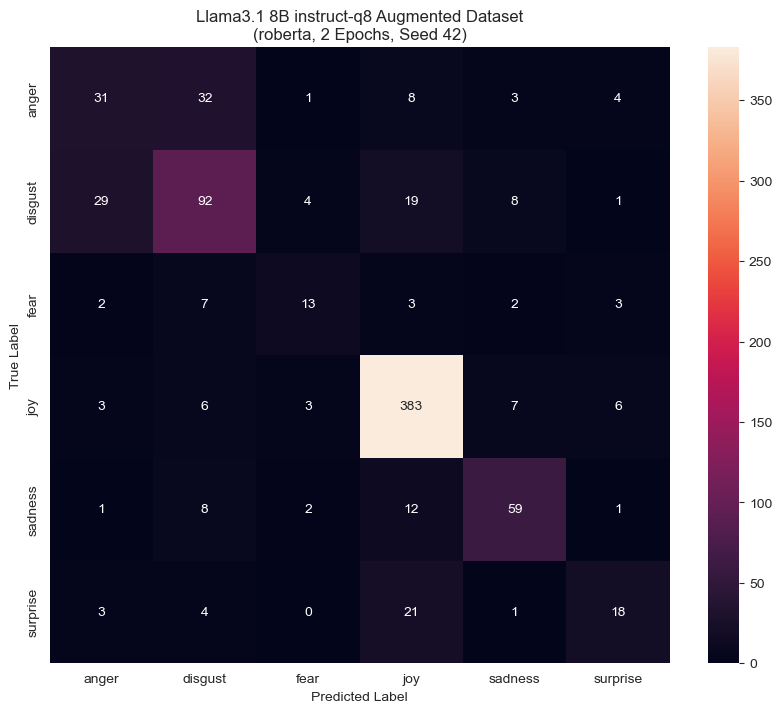

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(df_test["labels"], predictions),
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot=True, fmt="d",
            cmap="rocket")

if augment_by is not None:
    plt.title(f"{augmenting_llm} Augmented Dataset\n"
              f"({classifier}, {epochs} Epochs, Seed {classifier_random_seed})")
else:
    plt.title(f"Non-Augmented Dataset"
              f"({classifier}, {epochs} Epochs, Seed {classifier_random_seed})")
    
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

## Misclassified records

In [46]:
df_test["labels"] = le.inverse_transform(df_test["labels"])
df_test["predict"] = le.inverse_transform(predictions)

In [47]:
if augment_by is None:
    print(f"Dataset is augmented? False")
elif augment_by == "balance":
    print(f"Dataset is augmented to attempt class balance.")
elif isinstance(augment_by, int):
    print(f"Dataset is augmented to add {augment_by} records to each class.")
elif augment_by == "initial size":
    print("Dataset class size was reduced and then augmented to initial class size.")

df_test[df_test["labels"] != df_test["predict"]]

,text,labels,predict
95,"Suarez celebration against Liverpool, his form...",disgust,anger
4838,Ok enough already. When is Ghost coming back? ...,anger,joy
162,Reminding me of Madrid’s run in last few years...,joy,surprise
2209,Do Barcelona know this is a semi final coz the...,joy,surprise
1786,Hope every team on HASHTAG will lose.,disgust,sadness
...,...,...,...
577,HASHTAG USER I did not see the humor in your c...,disgust,anger
972,USER USER USER Are we talking about Irak? Or a...,anger,disgust
1362,"Folks, the Notre Dame is a fucking building. A...",anger,disgust
1817,"Don’t take your chances, don’t stay in the gam...",disgust,joy


In [48]:
# Remove model from GPU memory
import gc

with torch.no_grad():
    torch.cuda.empty_cache()
del model
gc.collect()

7053